# DD360 Coding Challenge: análisis del ciclo de desarrollo


## Paquetes necesarios 

In [1]:
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential
from keras.layers import Dense
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from matplotlib import pyplot as plt
import seaborn as sb
import matplotlib.pyplot as plt
import pandas as pd
import warnings 
warnings.filterwarnings('ignore')
warnings.filterwarnings('ignore', category=DeprecationWarning)
from xgboost import XGBRegressor

2023-05-26 02:38:10.406413: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-05-26 02:38:10.583705: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-05-26 02:38:10.585177: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-26 02:38:11.748127: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Importación y limpieza del Data Frame
Partimos importando el dataset mediante pandas y procederemos a hacer un análisis exploratorio de los datos.\

In [2]:
raw_data = pd.read_csv(r'reto_precios.csv')
raw_data['amenities'] = raw_data['amenities'].fillna(raw_data['amenities'].mean())
print(raw_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 981 entries, 0 to 980
Data columns (total 35 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   main_name             981 non-null    object 
 1   subtitle              981 non-null    object 
 2   link                  981 non-null    object 
 3   location              981 non-null    object 
 4   price                 981 non-null    object 
 5   attributes            981 non-null    object 
 6   timestamp             981 non-null    object 
 7   id                    981 non-null    int64  
 8   address               702 non-null    object 
 9   since                 981 non-null    object 
 10  description           981 non-null    object 
 11  vendor                981 non-null    object 
 12  lat                   981 non-null    float64
 13  lon                   981 non-null    float64
 14  price_mod             981 non-null    float64
 15  price_currency        9

Se implementó una función para limpiar el DataSet y manetner unicamente las columnas con features definidos en cada una de las observaciones.

In [3]:
def get_cols_with_no_nans(df,col_type):
    '''
    Arguments :
    df : The dataframe to process
    col_type : 
          num : to only get numerical columns with no nans
          no_num : to only get nun-numerical columns with no nans
          all : to get any columns with no nans    
    '''
    if (col_type == 'num'):
        predictors = df.select_dtypes(exclude=['object'])
    elif (col_type == 'no_num'):
        predictors = df.select_dtypes(include=['object'])
    elif (col_type == 'all'):
        predictors = df
    else :
        print('Error : choose a type (num, no_num, all)')
        return 0
    cols_with_no_nans = []
    for col in predictors.columns:
        if not df[col].isnull().any():
            cols_with_no_nans.append(col)
    return cols_with_no_nans

Se dividió el dataset entre los datos numéricos y no numéricos, aunque en un inicio se experimentó utilizando los datos no numéricos como parte del dataframe y codificandolos, no se obtuvieron buenos resultados por lo que se decidió trabajar únicamente con los datos numéricos.

In [4]:
num_cols = get_cols_with_no_nans(raw_data , 'num')
cat_cols = get_cols_with_no_nans(raw_data , 'no_num')
print ('Number of numerical columns with no nan values :',len(num_cols))
print ('Number of nun-numerical columns with no nan values :',len(cat_cols))

Number of numerical columns with no nan values : 14
Number of nun-numerical columns with no nan values : 12


Impresión en histograma de las features útilies, mediante este análisis podemos observar el comportamiento de cada feautre.

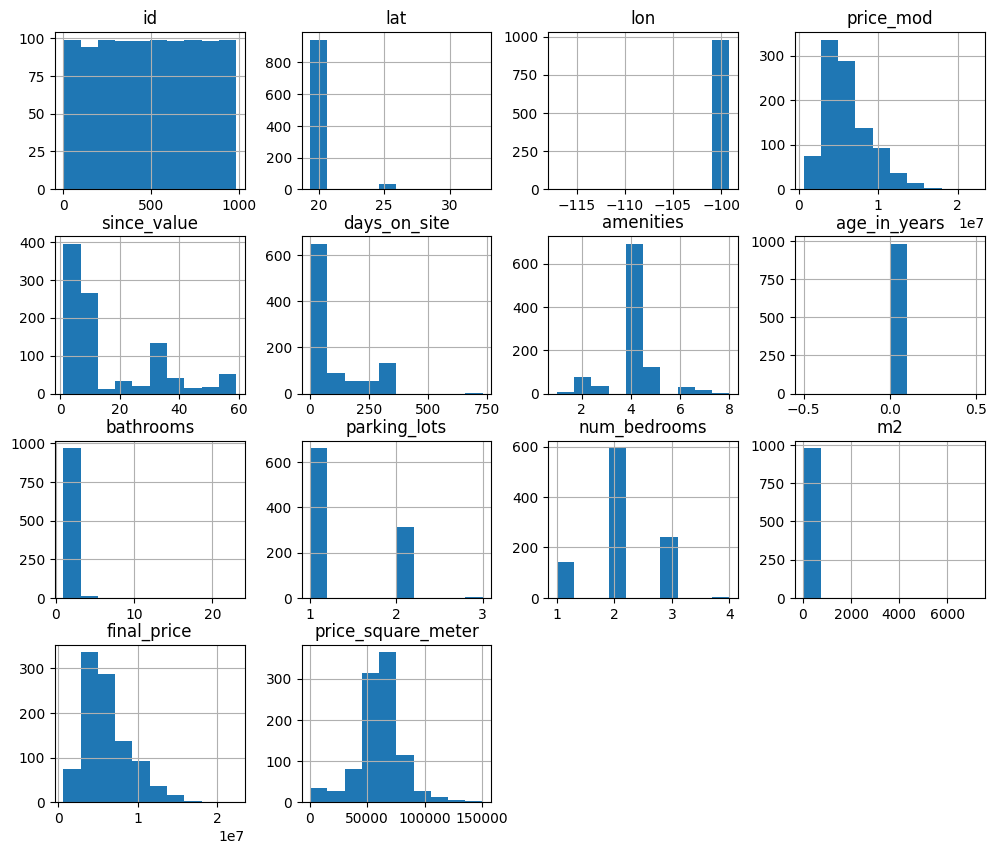

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 981 entries, 0 to 980
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id                  981 non-null    int64  
 1   lat                 981 non-null    float64
 2   lon                 981 non-null    float64
 3   price_mod           981 non-null    float64
 4   since_value         981 non-null    int64  
 5   days_on_site        981 non-null    float64
 6   amenities           981 non-null    float64
 7   age_in_years        981 non-null    float64
 8   bathrooms           981 non-null    float64
 9   parking_lots        981 non-null    int64  
 10  num_bedrooms        981 non-null    float64
 11  m2                  981 non-null    float64
 12  final_price         981 non-null    float64
 13  price_square_meter  981 non-null    float64
dtypes: float64(11), int64(3)
memory usage: 107.4 KB
None


In [5]:
combined = raw_data[num_cols]
combined.hist(figsize = (12,10))
plt.show()
print(combined.info())

Mediante un análisis de la correlación entre los datos numéricos podemos notar que el precio por metro cuadrado depende principalmente de la ubicación y cantidad de baños, aunque también es posible apreciar que el precio final tiene una correlación grande con la cantidad de habitaciones y lugares de estacionamiento disponibles. Por la correlación existente entre el precio total y el precio por metro cuadrado, podemos suponer que todas las features mencionadas son parte importante en la predicción del costo por metro cuadrado en los inmuebles.

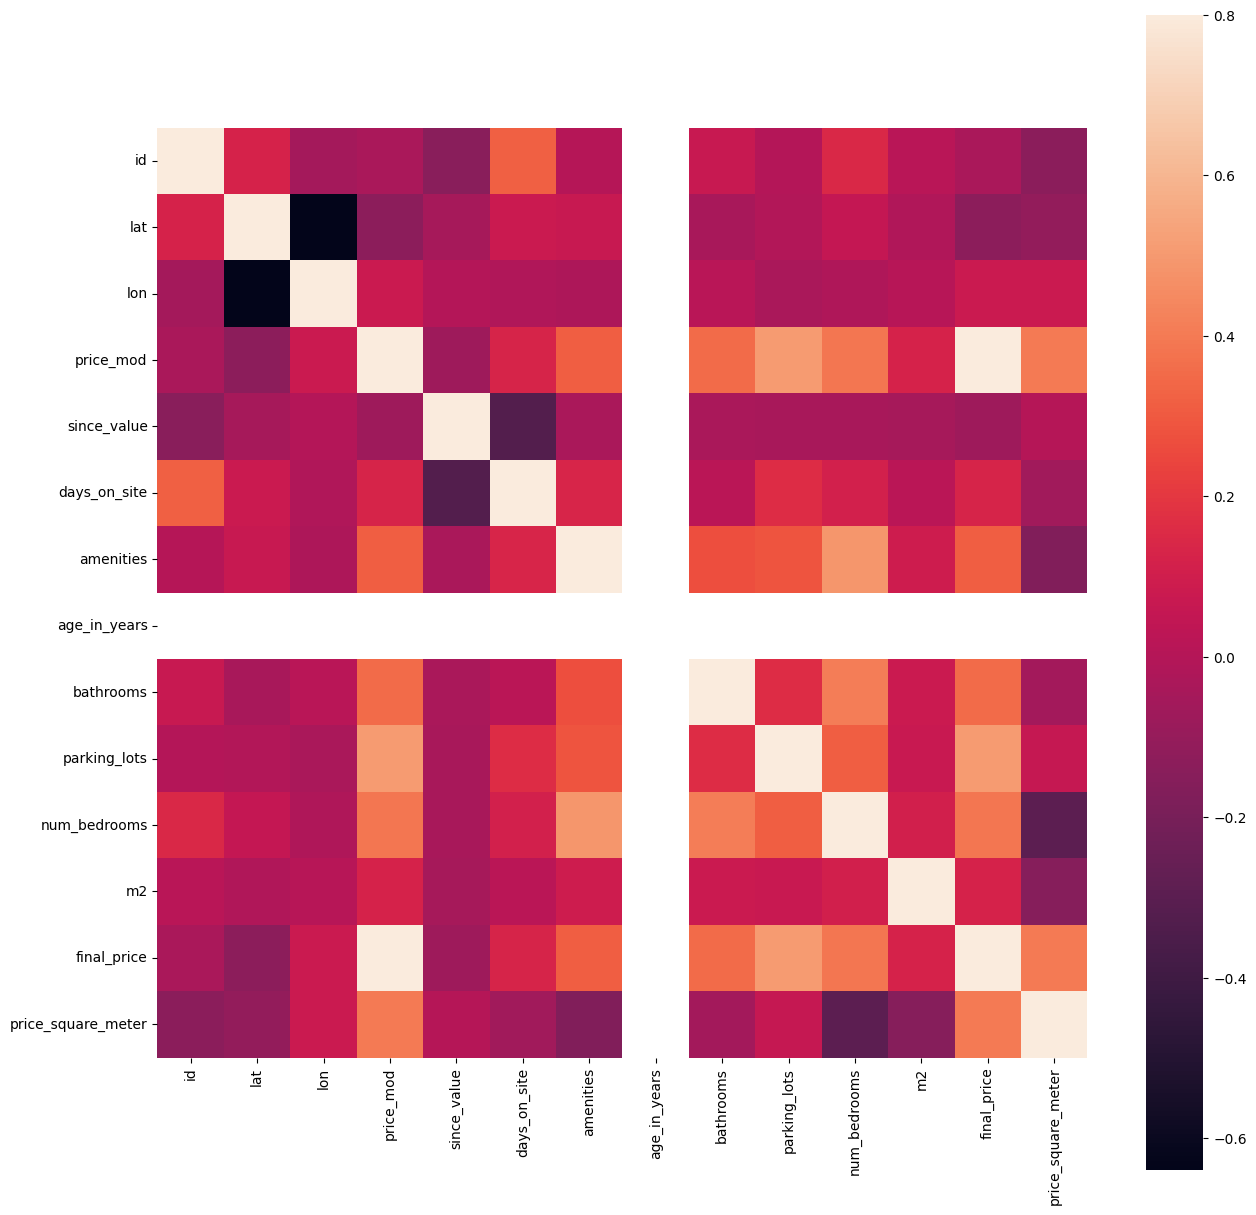

In [6]:
train_data = raw_data[num_cols]

C_mat = train_data.corr()
fig = plt.figure(figsize = (15,15))

sb.heatmap(C_mat, vmax = .8, square = True)
plt.show()

Se generó la división del data set en training set y test set, con 600 observaciones de entrenamiento y el resto de prueba.

In [7]:
def split_combined():
    global train_data
    train = train_data[:700]
    test = train_data[700:]

    return train , test 
  
train, test = split_combined()

Como consecuencia del análisis de los datos, dividimos nuestros dataframes de prueba y entrenamiento entre datos de entrada y salida.
Así mismo se optó por eliminar el la antiguedad del inmuble pues podría causar problemas en la convergencia del modelo.

In [8]:
train_x = train.drop(['final_price','price_square_meter','price_mod','id','age_in_years','m2','since_value','days_on_site'], axis=1)
train_y = train['price_square_meter']
test_x = test.drop(['final_price','price_square_meter','price_mod','id','age_in_years','m2','since_value','days_on_site'], axis=1)
test_y = test['price_square_meter']
print(train_x.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 700 entries, 0 to 699
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   lat           700 non-null    float64
 1   lon           700 non-null    float64
 2   amenities     700 non-null    float64
 3   bathrooms     700 non-null    float64
 4   parking_lots  700 non-null    int64  
 5   num_bedrooms  700 non-null    float64
dtypes: float64(5), int64(1)
memory usage: 32.9 KB
None


## Proposición y entrenamiento del modelo
Por la naturaleza del problema así como la cantidad "baja" de features en el dataset, se decidió entrenar tres modelos diferentes y llevar al primer ciclo de producción el más certero de ellos.

### Modelo de Red Neuronal 
Para este modelo se decidió utilizar 3 capas escondidas cada una cond 256 neuronas, la función de activación de estas es una función ReLU y la función de activación de la capa de salida es una regresión lineal.

In [9]:
NN_model = Sequential()

NN_model.add(Dense(4, kernel_initializer='normal',input_dim = train_x.shape[1], activation='relu'))

NN_model.add(Dense(8, kernel_initializer='normal',activation='relu'))
NN_model.add(Dense(8, kernel_initializer='normal',activation='relu'))
NN_model.add(Dense(6, kernel_initializer='normal',activation='relu'))

NN_model.add(Dense(1, kernel_initializer='normal',activation='linear'))

NN_model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error'])
NN_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 4)                 28        
                                                                 
 dense_1 (Dense)             (None, 8)                 40        
                                                                 
 dense_2 (Dense)             (None, 8)                 72        
                                                                 
 dense_3 (Dense)             (None, 6)                 54        
                                                                 
 dense_4 (Dense)             (None, 1)                 7         
                                                                 
Total params: 201
Trainable params: 201
Non-trainable params: 0
_________________________________________________________________


Se agregó un check_point para guardar la iteración con los valores más precisos dentro de 500 epochs de entrenamiento secuencial.

In [10]:
checkpoint_name = 'Weights-{epoch:05d}--{val_loss:.5f}.hdf5' 
checkpoint = ModelCheckpoint(checkpoint_name, monitor='val_loss', verbose = 1, save_best_only = True, mode ='auto')
callbacks_list = [checkpoint]

In [11]:
NN_model.fit(train_x, train_y, epochs=3000, batch_size=32, validation_split = 0.2, callbacks=callbacks_list)

Epoch 1/3000
 1/18 [>.............................] - ETA: 14s - loss: 64199.1484 - mean_absolute_error: 64199.1484
Epoch 1: val_loss improved from inf to 64939.62891, saving model to Weights-00001--64939.62891.hdf5
18/18 [==============================] - 1s 14ms/step - loss: 62665.4727 - mean_absolute_error: 62665.4727 - val_loss: 64939.6289 - val_mean_absolute_error: 64939.6289
Epoch 2/3000
 1/18 [>.............................] - ETA: 0s - loss: 60702.7031 - mean_absolute_error: 60702.7031
Epoch 2: val_loss improved from 64939.62891 to 64939.60156, saving model to Weights-00002--64939.60156.hdf5
18/18 [==============================] - 0s 5ms/step - loss: 62665.4414 - mean_absolute_error: 62665.4414 - val_loss: 64939.6016 - val_mean_absolute_error: 64939.6016
Epoch 3/3000
 1/18 [>.............................] - ETA: 0s - loss: 65028.1172 - mean_absolute_error: 65028.1172
Epoch 3: val_loss improved from 64939.60156 to 64939.52734, saving model to Weights-00003--64939.52734.hdf5
18/

In [12]:
wights_file = 'Weights-02999--13338.98047.hdf5' 
NN_model.load_weights(wights_file) 
NN_model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error'])
predictions = NN_model.predict(test_x)

9/9 [==============================] - 0s 963us/step


### Modelo de Regresión de Gradiente Extremo (XGBoost)

In [13]:
XGBModel = XGBRegressor(objective="reg:squarederror", random_state=42,max_depth=10)
XGBModel.fit(train_x,train_y, verbose=False)

XGBpredictions = XGBModel.predict(test_x)

### Modelo de Bosque Aleatorio (Random Forest Regression)

In [14]:
model = RandomForestRegressor()
model.fit(train_x,train_y)

RF_predictions = model.predict(test_x)

## Análisis de Resultados

Evaluación de la precisión de los tres modelos entrenados mediante tres métricas diferentes; MAE, MAPE y MSE. 

18729.293597946526
16305.161105157387
15888.492171986505


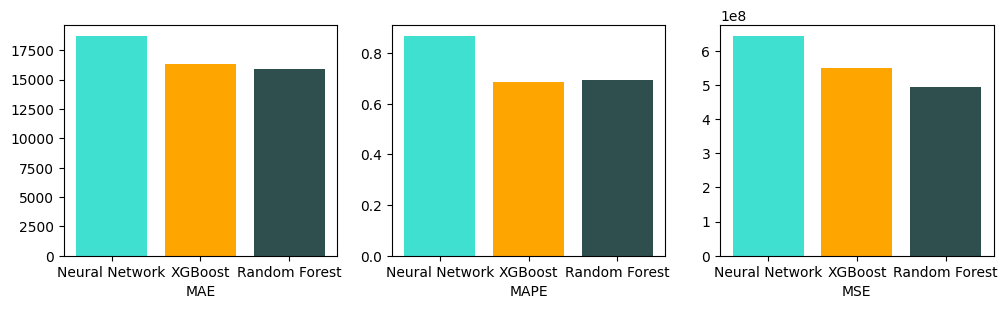

In [15]:
NN_MAE = mean_absolute_error(test_y, predictions)
NN_MAPE = mean_absolute_percentage_error(test_y, predictions)
NN_MSE = mean_squared_error(test_y, predictions)

XGB_MAE = mean_absolute_error(test_y , XGBpredictions)
XGB_MAPE = mean_absolute_percentage_error(test_y , XGBpredictions)
XGB_MSE = mean_squared_error(test_y , XGBpredictions)

RF_MAE = mean_absolute_error(test_y , RF_predictions)
RF_MAPE = mean_absolute_percentage_error(test_y , RF_predictions)
RF_MSE = mean_squared_error(test_y , RF_predictions)
print(NN_MAE)
print(XGB_MAE)
print(RF_MAE)

MAE_scores = [NN_MAE, XGB_MAE, RF_MAE]
MAPE_scores = [NN_MAPE, XGB_MAPE, RF_MAPE]
MSE_scores = [NN_MSE, XGB_MSE, RF_MSE]
results = [MAE_scores,MAPE_scores, MSE_scores]
models = ['Neural Network', "XGBoost", "Random Forest"]
labels = ['MAE', 'MAPE', 'MSE']
colors = ['Turquoise', 'Orange', 'Darkslategrey']
fig,ax = plt.subplots(1,3,figsize=(12,3))
for i in range(len(labels)):
    for j in range(len(colors)):
        ax[i].bar(models[j],results[i][j], color=colors[j])
    ax[i].set_xlabel(labels[i])
plt.show()

Nótese que los mejores resultados fueron obtenidos por los modelos de regresión XGBoost y Random Forest, puede que esto se deba a un bajo poder de cómputo a la hora de entrenar a la raíz neuronal o algún fallo en la parametrización/normalización del dataframe. 
Así entonces se optó por implementar el modelo de XGBoost Regression en el despliegue a producción.